In [24]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import shap
from sklearn.model_selection import train_test_split
import seaborn as sns

### Load Data

Загрузим датасет

In [2]:
# load data
CSV = '/kaggle/input/iotintrusion/IoT_Intrusion.csv'
df = pd.read_csv(CSV)
df

,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,...,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,label
0,0.000000,54.00,6.00,64.00,0.329807,0.329807,0.0,1,0,1,...,0.000000,54.00,8.334383e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55,DDoS-RSTFINFlood
1,0.000000,57.04,6.33,64.00,4.290556,4.290556,0.0,0,0,0,...,2.822973,57.04,8.292607e+07,9.5,10.464666,4.010353,160.987842,0.05,141.55,DoS-TCP_Flood
2,0.000000,0.00,1.00,64.00,33.396799,33.396799,0.0,0,0,0,...,0.000000,42.00,8.312799e+07,9.5,9.165151,0.000000,0.000000,0.00,141.55,DDoS-ICMP_Flood
3,0.328175,76175.00,17.00,64.00,4642.133010,4642.133010,0.0,0,0,0,...,0.000000,50.00,8.301570e+07,9.5,10.000000,0.000000,0.000000,0.00,141.55,DoS-UDP_Flood
4,0.117320,101.73,6.11,65.91,6.202211,6.202211,0.0,0,1,0,...,23.113111,57.88,8.297300e+07,9.5,11.346876,32.716243,3016.808286,0.19,141.55,DoS-SYN_Flood
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,1.391925,108.00,6.00,64.00,1.437685,1.437685,0.0,0,1,0,...,0.000000,54.00,8.336550e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55,DDoS-SynonymousIP_Flood
1048571,0.000000,2.14,46.70,65.91,0.000000,0.000000,0.0,0,0,0,...,5.281048,588.22,8.367732e+07,9.5,34.370618,7.497140,469.190222,0.06,141.55,Mirai-greeth_flood
1048572,0.132971,30847.00,17.00,64.00,5978.034950,5978.034950,0.0,0,0,0,...,0.000000,50.00,8.312373e+07,9.5,10.000000,0.000000,0.000000,0.00,141.55,DDoS-UDP_Flood
1048573,0.000000,54.00,6.00,64.00,25.672981,25.672981,0.0,1,0,1,...,0.000000,54.00,8.334509e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55,DDoS-RSTFINFlood


Избавимся от пробелов в названии колонок

In [3]:
# change column names
df.columns = ['_'.join(c.split(' ')).lower() for c in df.columns]

Удалим пропуски в данных

In [4]:
# drop NULLs & reset index
df.dropna(inplace=True)
df.reset_index(inplace=True, drop=True)

Поменяем таргет под нашу задачу

* 1 - ddos атака
* 0 - другая атака

In [5]:
df['label'] = df['label'].apply(lambda x: 1 if str(x).lower().startswith('ddos') else 0)
df

,flow_duration,header_length,protocol_type,duration,rate,srate,drate,fin_flag_number,syn_flag_number,rst_flag_number,...,std,tot_size,iat,number,magnitue,radius,covariance,variance,weight,label
0,0.000000,54.00,6.00,64.00,0.329807,0.329807,0.0,1,0,1,...,0.000000,54.00,8.334383e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55,1
1,0.000000,57.04,6.33,64.00,4.290556,4.290556,0.0,0,0,0,...,2.822973,57.04,8.292607e+07,9.5,10.464666,4.010353,160.987842,0.05,141.55,0
2,0.000000,0.00,1.00,64.00,33.396799,33.396799,0.0,0,0,0,...,0.000000,42.00,8.312799e+07,9.5,9.165151,0.000000,0.000000,0.00,141.55,1
3,0.328175,76175.00,17.00,64.00,4642.133010,4642.133010,0.0,0,0,0,...,0.000000,50.00,8.301570e+07,9.5,10.000000,0.000000,0.000000,0.00,141.55,0
4,0.117320,101.73,6.11,65.91,6.202211,6.202211,0.0,0,1,0,...,23.113111,57.88,8.297300e+07,9.5,11.346876,32.716243,3016.808286,0.19,141.55,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,1.391925,108.00,6.00,64.00,1.437685,1.437685,0.0,0,1,0,...,0.000000,54.00,8.336550e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55,1
1048571,0.000000,2.14,46.70,65.91,0.000000,0.000000,0.0,0,0,0,...,5.281048,588.22,8.367732e+07,9.5,34.370618,7.497140,469.190222,0.06,141.55,0
1048572,0.132971,30847.00,17.00,64.00,5978.034950,5978.034950,0.0,0,0,0,...,0.000000,50.00,8.312373e+07,9.5,10.000000,0.000000,0.000000,0.00,141.55,1
1048573,0.000000,54.00,6.00,64.00,25.672981,25.672981,0.0,1,0,1,...,0.000000,54.00,8.334509e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55,1


Разобьем на трейновую и тестовую выборки
тест - 20%, трейн - 80%
Разбиваем перемешанный датасет с учетом сохранения одинковых пропорций таргета в трейне и тесте

In [16]:
x, y = df.iloc[:,:-1], df['label']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True, stratify=y)

Для бинарной классификации воспользуемся случайным лесом

In [18]:
RFC = RandomForestClassifier()
RFC.fit(x_train, y_train)
y_pred = RFC.predict(x_test)

Оценим предсказание с помощью F1 меры, так как она учитывает несбалансированность классов

In [19]:
f1_score(y_test, y_pred)

0.9997609934813428

Визуализация важности признаков: 

Оценим важность признаков двумя способами - самой моделью и shap values. 

Сама моедль не всегда надежно оценивает важность признаков, так как может быть смещена в сторону категориальных признаков с большим кол-вом уникальных значений.

Случайный лес автоматически рассчитывает важность признаков на основе:

* Gini Importance (среднее уменьшение неопределенности при разбиении узлов)
* Mean Decrease Impurity (насколько признак уменьшает "нечистоту" в дереве)

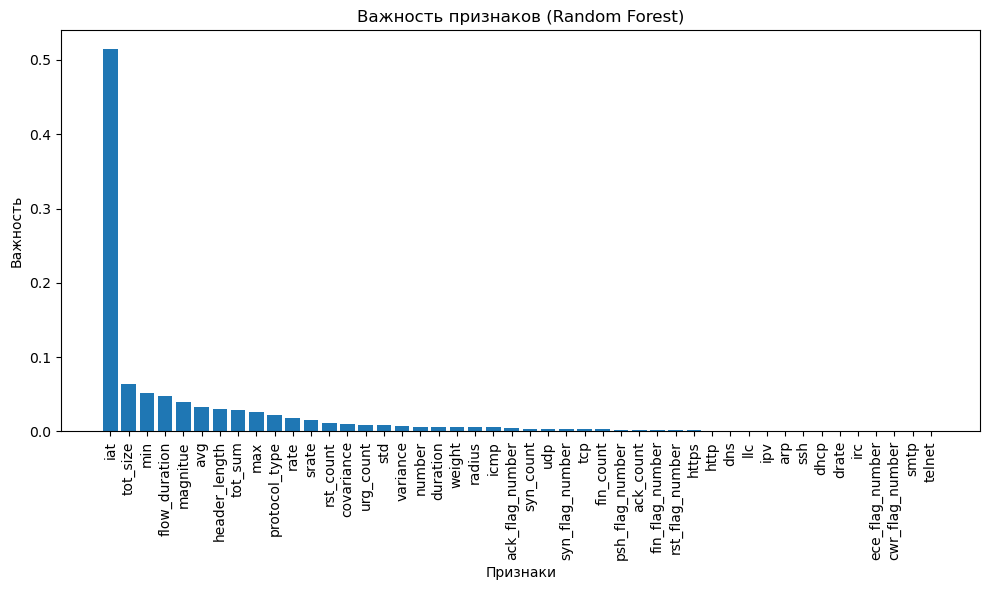

In [20]:
importances = RFC.feature_importances_
feature_names = x_train.columns  # или список названий признаков

# Сортируем признаки по важности
indices = np.argsort(importances)[::-1]

# Визуализация
plt.figure(figsize=(10, 6))
plt.title("Важность признаков (Random Forest)")
plt.bar(range(x_train.shape[1]), importances[indices], align="center")
plt.xticks(range(x_train.shape[1]), feature_names[indices], rotation=90)
plt.xlabel("Признаки")
plt.ylabel("Важность")
plt.tight_layout()
plt.show()

Описание результатов

**DDoS (Distributed Denial of Service)** — это атака, цель которой перегрузить сервер или сеть большим количеством запросов.

1. Аномалии в IAT (Inter-Arrival Time)

Почему важен?

Низкий IAT: DDoS-атаки часто генерируют очень частые запросы (пакеты приходят почти одновременно).

Резкие скачки: Вместо плавного распределения, IAT будет близок к 0 или хаотично меняться.

Пример:

Нормальный трафик: IAT = 100-500 мс.
DDoS: IAT < 10 мс (ботнет шлёт запросы без задержек).

2. Размеры пакетов (Tot size, AVG)

Мелкие пакеты:
DDoS часто использует маленькие пакеты (например, AVG = 50-100 байт).


3. Длительность (flow_duration)

Короткие соединения:
Множество потоков с flow_duration < 1 сек (ботнет не поддерживает долгие сессии).

Оценим важность признаков с помощью библиотеки shap

SHAP — это метод интерпретации моделей машинного обучения, основанный на теории игр Шепли (Shapley values). Он объясняет вклад каждого признака в предсказание модели, распределяя "справедливый" вклад каждого признака среди всех возможных комбинаций.


SHAP отвечает на вопрос:
"Насколько каждый признак влияет на предсказание модели по сравнению со средним прогнозом?"

Каждому признаку присваивается SHAP-значение, которое показывает его вклад в итоговый прогноз.
Сумма всех SHAP-значений равна разнице между предсказанием модели и средним предсказанием (базовым значением).
Формула:

Предсказание = Базовое значение + $\sum_{i=1}^n SHAP_i$,
где:
* Базовое значение (base value) — средний прогноз модели на всех данных.
* $SHAP_i$ — вклад i-го признака.

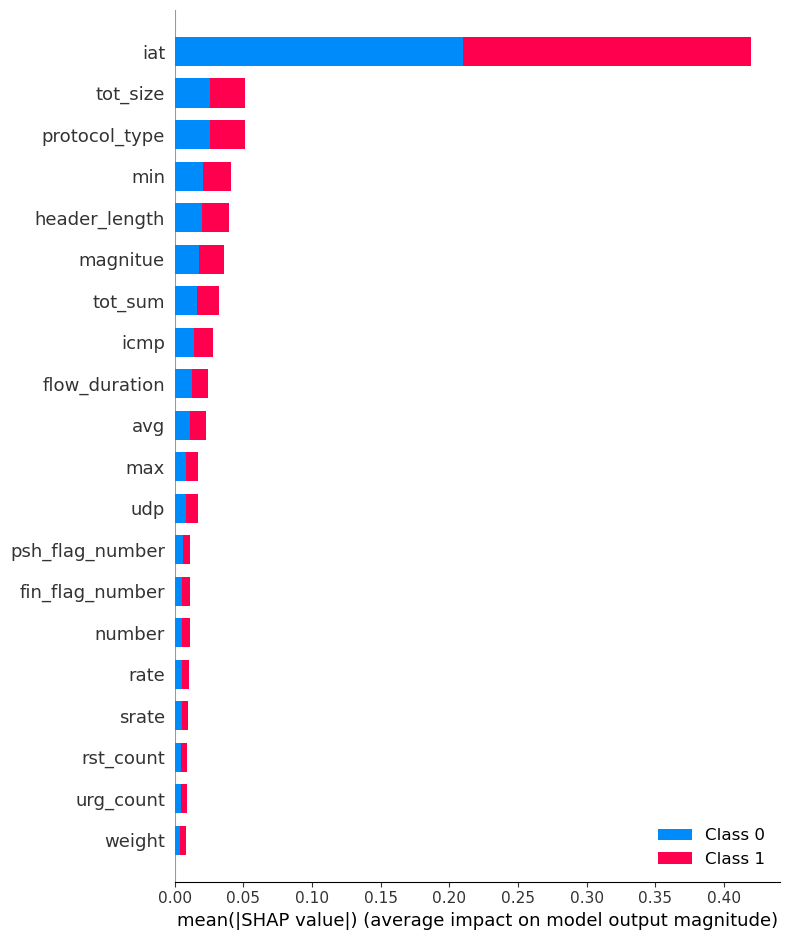

In [21]:
# Создаем объяснитель
sample = x_train.sample(10_000, random_state=42)  # берём 1% данных
explainer = shap.TreeExplainer(RFC)
shap_values = explainer.shap_values(sample)

# Визуализация важности признаков
shap.summary_plot(shap_values, sample, plot_type="bar")

Видим что оценка важности признаков с помощью shap довольно близка к оцениванию с помощью самой модели 

Рассмотрим значаения для IAT

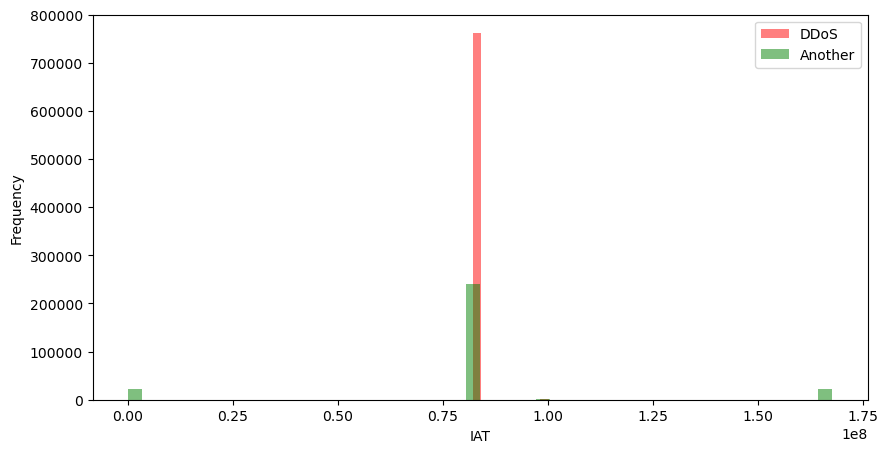

In [30]:
# Гистограмма IAT для атак и нормы
plt.figure(figsize=(10, 5))
plt.hist(df[df['label'] == 1]['iat'], bins=50, alpha=0.5, label='DDoS', color='red')
plt.hist(df[df['label'] == 0]['iat'], bins=50, alpha=0.5, label='Another', color='green')
plt.xlabel('IAT')
plt.ylabel('Frequency')
plt.legend()
plt.show()

Видим что скорее всего в данных присутстсвуют выбросы так как в основном атаки находятся в райне 8*$10^7$

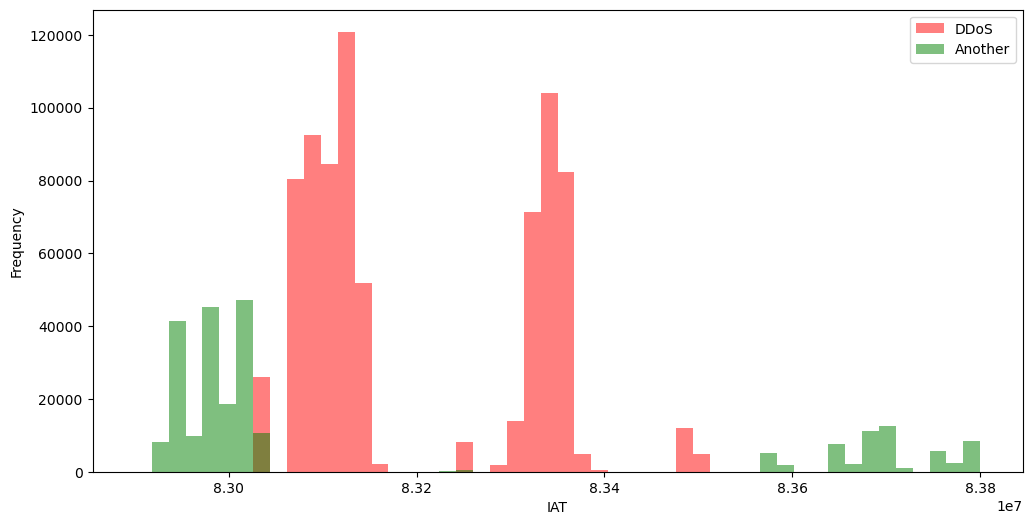

In [36]:
# Устанавливаем диапазон оси X
x_range = (829e5, 838e5)  # 8*10^7 = 80,000,000

plt.figure(figsize=(12, 6))

# Гистограмма для DDoS (label=1)
plt.hist(df[df['label'] == 1]['iat'], 
         bins=50, 
         range=x_range,  # Фиксируем диапазон
         alpha=0.5, 
         label='DDoS', 
         color='red')

# Гистограмма для нормального трафика (label=0)
plt.hist(df[df['label'] == 0]['iat'], 
         bins=50, 
         range=x_range,  # Фиксируем диапазон
         alpha=0.5, 
         label='Another', 
         color='green')
plt.xlabel('IAT')
plt.ylabel('Frequency')
plt.legend()
plt.show()

Inter-Arrival Time — это время между поступлением двух последовательных пакетов в сетевом потоке.

Единицы измерения: наносекунды (ns).

Теперь рассмотрим типы протоколов которые чаще всего используются при DDoS атаках

In [29]:
df['protocol_type'].unique()

array([ 6.  ,  6.33,  1.  , ..., 39.2 ,  5.42, 22.44])

непонятно что это вообще такое, возможно проблема в самом датасете - как вариант нумерация типов, но тогда она должна быть недробной

Теперь попробуем добавить атаки, которые являлись DDoS, но при этом снизим IAT

In [38]:
# 1. Найдем все DDoS-строки (label=1)
ddos_rows = df[df['label'] == 1].copy()

# 2. Меняем iat на 8*10^7 (80,000,000) в копиях
ddos_rows['iat'] = 8e7  # 80 миллионов

# 3. Добавляем измененные строки к исходному датафрейму
df_modified = pd.concat([df, ddos_rows], ignore_index=True)
df_modified

,flow_duration,header_length,protocol_type,duration,rate,srate,drate,fin_flag_number,syn_flag_number,rst_flag_number,...,std,tot_size,iat,number,magnitue,radius,covariance,variance,weight,label
0,0.000000,54.00,6.00,64.00,0.329807,0.329807,0.0,1,0,1,...,0.000000,54.00,83343831.92,9.5,10.392305,0.000000,0.000000,0.00,141.55,1
1,0.000000,57.04,6.33,64.00,4.290556,4.290556,0.0,0,0,0,...,2.822973,57.04,82926067.47,9.5,10.464666,4.010353,160.987842,0.05,141.55,0
2,0.000000,0.00,1.00,64.00,33.396799,33.396799,0.0,0,0,0,...,0.000000,42.00,83127993.93,9.5,9.165151,0.000000,0.000000,0.00,141.55,1
3,0.328175,76175.00,17.00,64.00,4642.133010,4642.133010,0.0,0,0,0,...,0.000000,50.00,83015696.38,9.5,10.000000,0.000000,0.000000,0.00,141.55,0
4,0.117320,101.73,6.11,65.91,6.202211,6.202211,0.0,0,1,0,...,23.113111,57.88,82972999.18,9.5,11.346876,32.716243,3016.808286,0.19,141.55,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1812095,0.000000,54.00,6.00,64.00,2.986855,2.986855,0.0,0,0,0,...,0.000000,54.00,80000000.00,9.5,10.392305,0.000000,0.000000,0.00,141.55,1
1812096,0.000000,0.00,1.00,64.00,4.117001,4.117001,0.0,0,0,0,...,0.000000,42.00,80000000.00,9.5,9.165151,0.000000,0.000000,0.00,141.55,1
1812097,1.391925,108.00,6.00,64.00,1.437685,1.437685,0.0,0,1,0,...,0.000000,54.00,80000000.00,9.5,10.392305,0.000000,0.000000,0.00,141.55,1
1812098,0.132971,30847.00,17.00,64.00,5978.034950,5978.034950,0.0,0,0,0,...,0.000000,50.00,80000000.00,9.5,10.000000,0.000000,0.000000,0.00,141.55,1


Теперь оценим модель на данном датасете

In [40]:
x_mod, y_mod = df_modified.iloc[:,:-1], df_modified['label']
y_mod_pred = RFC.predict(x_mod)
f1_score(y_mod, y_mod_pred)

0.8499680127662763

Можем увидеть что качество довольно сильно просело, а значит этот признак сильно влияет на классификацию DDoS атак